<a href="https://www.kaggle.com/code/yorkyong/sentiment-analysis-with-llama-3-1?scriptVersionId=202324555" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#with reference from https://www.kaggle.com/code/lucamassaron/fine-tune-llama-2-for-sentiment-analysis

In [2]:
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import re
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoConfig,
                          AutoModelForCausalLM, 
                          AutoTokenizer,
                          LlamaForCausalLM, 
                          LlamaTokenizer,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [6]:
pd.set_option('display.max_colwidth', None)  # Show full width of each column

In [7]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.4.0


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


# Preparing the data and the core evaluation functions

In [9]:
filename1= '/kaggle/input/mcdonalds-review-dataset-6-months-clean-sentiment/cleaned_data.csv'
filename2= "/kaggle/input/mcdonalds-review-dataset-6-months-clean-sentiment/cleaned_data_additional.csv"

In [10]:
# # cleaned dataset with reassigned sentiments
# filename = '/kaggle/input/mcdonalds-review-dataset-6-months-clean-sentiment/Mcdonald_review - 6 months - 40 stores - checked.csv'

In [11]:
# filename = "/kaggle/input/mcdonalds-store-reviews/McDonald_s_Reviews.csv"

In [12]:
df = pd.read_csv(filename1,encoding="utf8", encoding_errors="replace")
df_add = pd.read_csv(filename2,encoding="utf8", encoding_errors="replace")

In [13]:
df.head()

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
0,"621 Broadway, Newark, NJ 07104, United States",7104,19164,5 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
1,"621 Broadway, Newark, NJ 07104, United States",7104,27527,6 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
2,"621 Broadway, Newark, NJ 07104, United States",7104,19183,3 months ago,negative,Horrible service from the night shift manager .!! I would also love to speak to a distric manager.!,horrible service night shift manager would also love speak distric manager
3,"621 Broadway, Newark, NJ 07104, United States",7104,19162,2 weeks ago,negative,"I only eat at this specific location when I don���������������������������t have time to travel elsewhere. The McDonalds at Newark Penn Station AND Broad & Market street got way better service than this one. No one speaks English, so there�������",eat specific dont time travel elsewhere newark penn station broad market street got way better service one one speaks english
4,"621 Broadway, Newark, NJ 07104, United States",7104,19165,3 weeks ago,negative,"It sucks because this place does have good staff, but there���������������������������s also staff that just doesn���������������������������t care. I ordered an iced caramel frapuccino in the drive thru, they asked me to park and had someone bring a hot frappe. I told the woman it should���������������������������v",suck place good staff there also staff doesnt care ordered iced caramel frapuccino drive thru asked park someone bring hot frappe told woman shouldv


In [14]:
df_add.head()

,Unnamed: 0,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,service,cleanliness,food,price,others
0,27,"621 Broadway, Newark, NJ 07104, United States",7104,306,9 months ago,neutral,"Prices were as expected for fast food, no surprises.",price expected fast surprise,0,0,0,2,0
1,63,"621 Broadway, Newark, NJ 07104, United States",7104,851,9 months ago,neutral,The self-service drink station was functioning,selfservice drink station functioning,0,2,0,0,0
2,99,"621 Broadway, Newark, NJ 07104, United States",7104,1663,9 months ago,neutral,The main counter had a laminate surface,main counter laminate surface,0,2,0,0,0
3,135,"621 Broadway, Newark, NJ 07104, United States",7104,1978,8 months ago,neutral,The cashier asked if the customer wanted to add any items to their order,cashier asked customer wanted add item,2,0,0,0,0
4,171,"621 Broadway, Newark, NJ 07104, United States",7104,2759,8 months ago,neutral,Sundaes were topped with chocolate or caramel sauce,sundae topped chocolate caramel sauce,0,0,2,0,0


# Combine df and df_add

In [15]:
# Drop the irrelevant columns in df_add
df_add_filtered = df_add[['store_address', 'location', 'reviewer_id', 'review_time', 'actual_sentiment', 'review', 'token_review_clean']]

# Use pd.concat to append df_add_filtered to df
df_combined = pd.concat([df, df_add_filtered], ignore_index=True)

# Display the result
df_combined

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
0,"621 Broadway, Newark, NJ 07104, United States",7104,19164,5 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
1,"621 Broadway, Newark, NJ 07104, United States",7104,27527,6 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
2,"621 Broadway, Newark, NJ 07104, United States",7104,19183,3 months ago,negative,Horrible service from the night shift manager .!! I would also love to speak to a distric manager.!,horrible service night shift manager would also love speak distric manager
3,"621 Broadway, Newark, NJ 07104, United States",7104,19162,2 weeks ago,negative,"I only eat at this specific location when I don���������������������������t have time to travel elsewhere. The McDonalds at Newark Penn Station AND Broad & Market street got way better service than this one. No one speaks English, so there�������",eat specific dont time travel elsewhere newark penn station broad market street got way better service one one speaks english
4,"621 Broadway, Newark, NJ 07104, United States",7104,19165,3 weeks ago,negative,"It sucks because this place does have good staff, but there���������������������������s also staff that just doesn���������������������������t care. I ordered an iced caramel frapuccino in the drive thru, they asked me to park and had someone bring a hot frappe. I told the woman it should���������������������������v",suck place good staff there also staff doesnt care ordered iced caramel frapuccino drive thru asked park someone bring hot frappe told woman shouldv
...,...,...,...,...,...,...,...
2784,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,1627,10 months ago,neutral,Electrical outlets were present on some walls,electrical outlet present wall
2785,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,1946,11 months ago,neutral,Customers used the self-service kiosks to place orders,customer used selfservice kiosk place order
2786,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,2560,10 months ago,neutral,The Double Cheeseburger had two beef patties and two slices of cheese,double cheeseburger two beef patty two slice cheese
2787,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,3091,10 months ago,neutral,The restaurant offered free Wi-Fi to customers,restaurant offered free wifi customer


In [16]:
df = df_combined

# Train test split with stratification by sentiment

In [17]:
X_train = []
X_test = []
X_eval = []

# Iterate through the unique sentiments to split data into train, test, and eval
for sentiment in ["positive", "neutral", "negative"]:
    # Split into train and test
    train, test = train_test_split(
        df[df.actual_sentiment == sentiment], test_size=0.3, random_state=42
    )
    
    # Split remaining data for evaluation
    test, eval_split = train_test_split(test, test_size=0.5, random_state=42)
    
    # Append to respective lists
    X_train.append(train)
    X_test.append(test)
    X_eval.append(eval_split)

# Concatenate the results
X_train = pd.concat(X_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
X_eval = pd.concat(X_eval).reset_index(drop=True)



In [18]:
print(f"The train set for modelling has {len(X_train)} rows.")
print(f"The test set for modelling has {len(X_test)} rows.")
print(f"The eval set for modelling has {len(X_eval)} rows.")

The train set for modelling has 1951 rows.
The test set for modelling has 418 rows.
The eval set for modelling has 420 rows.


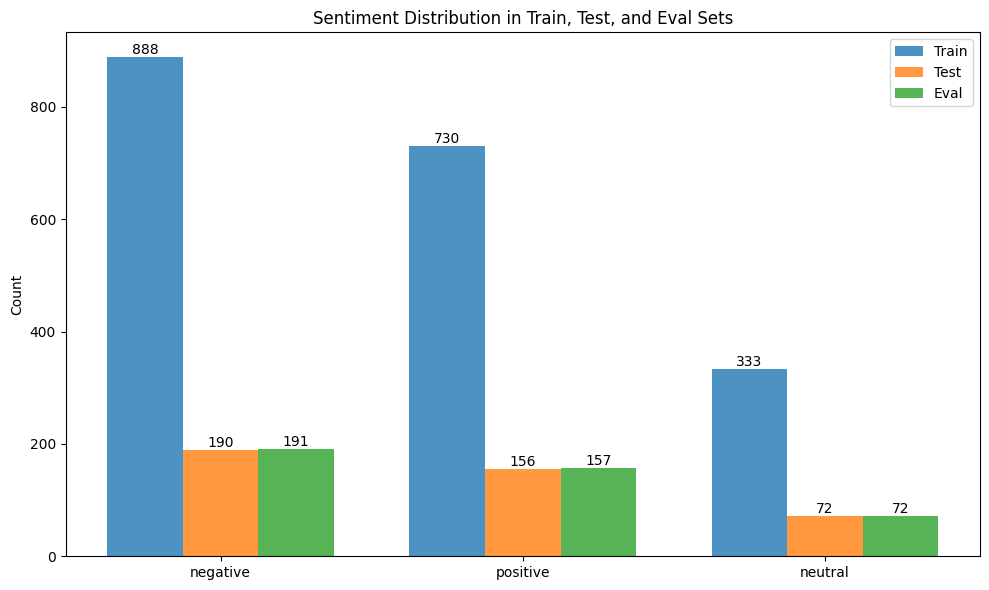

In [19]:
import matplotlib.pyplot as plt

def plot_sentiment_distribution(X_train, X_test, X_eval):
    # Count sentiments in train, test, and eval sets
    train_counts = X_train['actual_sentiment'].value_counts()
    test_counts = X_test['actual_sentiment'].value_counts()
    eval_counts = X_eval['actual_sentiment'].value_counts()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars
    x = range(len(train_counts))
    width = 0.25  # Adjust width for three groups
    ax.bar([i - width for i in x], train_counts.values, width, label='Train', alpha=0.8)
    ax.bar([i for i in x], test_counts.values, width, label='Test', alpha=0.8)
    ax.bar([i + width for i in x], eval_counts.values, width, label='Eval', alpha=0.8)

    # Customize the plot
    ax.set_ylabel('Count')
    ax.set_title('Sentiment Distribution in Train, Test, and Eval Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(train_counts.index)
    ax.legend()

    # Add value labels on top of each bar for Train, Test, and Eval
    for i, v in enumerate(train_counts.values):
        ax.text(i - width, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(test_counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(eval_counts.values):
        ax.text(i + width, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_sentiment_distribution(X_train, X_test, X_eval)


In [20]:
X_train

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
0,"6875 Sand Lake Rd, Orlando, FL 32819, United States",32819,13935,a month ago,positive,Super cool and fun international McDonald's! We loved the Wood Fired Pizza and all the different languages spoken there as well as the Arcade upstairs.,super cool fun international loved wood fired pizza different language spoken well arcade upstairs
1,"3501 Biscayne Blvd, Miami, FL 33137, United States",33137,33254,6 months ago,positive,Good place very good attention,good place good attention
2,"210 5th S, Salt Lake City, UT 84106, United States",84106,8482,3 weeks ago,positive,"Excellent customer service. The gentleman at the drive thru was friendly, helpful, and courteous.",excellent customer service gentleman drive thru friendly helpful courteous
3,"6875 Sand Lake Rd, Orlando, FL 32819, United States",32819,13966,2 months ago,positive,"Great food. Staff is amazing, unlike any other Mcdonalds you would go to!!!! Better to come here not during its peak",great staff amazing unlike would go better come peak
4,"1540 2nd St, Santa Monica, CA 90405, United States",90405,13177,6 months ago,positive,Always very quick and helpful,always quick helpful
...,...,...,...,...,...,...,...
1946,"By Mandalay Bay, 3999 S Las Vegas Blvd, Las Vegas, NV 89119, United States",89119,21142,5 months ago,negative,"If you are looking for something to eat on the way out of town, avoid this McDonalds like the plague. Diet Coke had no carbonation, and the food tasted absolutely vile. Tasted nothing like McDonalds is supposed to taste like. Maybe try the McDonalds in Primm instead.",looking something eat way town avoid like plague diet coke carbonation tasted absolutely vile tasted nothing like supposed taste like maybe try primm instead
1947,"690 Alameda St, Los Angeles, CA 90021, United States",90021,10116,a month ago,negative,Came on specially for an ice-cream cone. I was told that the machine was not working.\nVery Disappointed,came specially icecream cone told machine working disappointed
1948,"501 W Imperial Hwy, Los Angeles, CA 90044, United States",90044,12505,a month ago,negative,"Ive gone to this location several times. And today was by far the most unpleasant visit I've had. It was just the absolute worst! I'm taking my Son to work and decide to stop and get him lunch, and as soon as I'm ordering through the intercom , I can already tell the demeanor of the worker was comming off pretty rude. Once. We approached the window , when I gave her my code for my McDonald's Rewards she right away got even more rude with her whole body and facial expressions and didn't want to take my code , but in a very bad mood overall. Her attitude was so unpleasant. Being a McDonald's customer for years, I Didn't appreciate her behavior , she just ruined my whole mood and day. Her manager came to explain to me the situation in a much calmer , respectful manner. I mean, thats all Griselda had to do. Employees like this need to get trained better on how to properly interact with customers. Once you're clocked in, you're clocked in and should be ready to go. Trust me. I know. I've worked in customer service for 18 years. So I hope this McDonald's location properly trains Griselda accordingly.",gone several time today far unpleasant visit absolute worst taking son work decide stop get lunch soon ordering intercom already tell demeanor worker comming pretty rude approached window gave code reward right away got even rude whole body facial expression want take code bad mood overall attitude unpleasant customer year appreciate behavior ruined whole mood day manager came explain situation much calmer respectful manner mean griselda employee like need get trained better properly interact customer clocked clocked ready go trust know worked customer service year hope properly train griselda accordingly
1949,"25200 I-10 Lot 2, San Antonio, TX 78257, United States",78257,14116,5 months ago,negative,Do

In [21]:
def generate_prompt(data_point):
    """
    Generates a prompt including the review and the known sentiment label.
    
    Args:
        data_point (dict): A dictionary containing 'review' and 'sentiment' keys.
        
    Returns:
        str: A formatted prompt with the review and its sentiment label.
    """
    return f"""
    Analyze the sentiment of the review enclosed in square brackets, 
    determine if it is positive, neutral, or negative, and return the answer as 
    the corresponding sentiment label "positive" or "neutral" or "negative".

    [{data_point["review"]}] = {data_point["actual_sentiment"]}
    """.strip()

def generate_test_prompt(data_point):
    """
    Generates a test prompt including the review but omitting the sentiment label for prediction.
    
    Args:
        data_point (dict): A dictionary containing 'review' key.
        
    Returns:
        str: A formatted prompt with the review, without the sentiment label.
    """
    return f"""
    Analyze the sentiment of the review enclosed in square brackets, 
    determine if it is positive, neutral, or negative, and return the answer as 
    the corresponding sentiment label "positive" or "neutral" or "negative".

    [{data_point["review"]}] = """.strip()


In [22]:
# Generate the full prompt (input) and retain sentiment as a separate column
X_train['prompt'] = X_train.apply(generate_prompt, axis=1)
X_eval['prompt'] = X_eval.apply(generate_prompt, axis=1)

# Select the prompt (review) and sentiment for training and evaluation
X_train = X_train[['prompt', 'actual_sentiment']]
X_eval = X_eval[['prompt', 'actual_sentiment']]

y_true = X_test.actual_sentiment

# For X_test, generate the test prompt without sentiment and keep it as a DataFrame
X_test['prompt'] = X_test.apply(generate_test_prompt, axis=1)
X_test = X_test[['prompt']]

# Now convert the DataFrame to a dataset
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [23]:
train_data

Dataset({
    features: ['prompt', 'actual_sentiment'],
    num_rows: 1951
})

In [24]:
eval_data

Dataset({
    features: ['prompt', 'actual_sentiment'],
    num_rows: 420
})

In [25]:
X_test

,prompt
0,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [Dream,this place was amazing,I mean the food was expensive but really good and the arcade had amazing games but unfortunately the prize room was closed cuz of COVID but this was a good experience] ="
1,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [We had an amazing experience you ordered upfront and got your number, and they brought the food to you. You can personalize your own spaghetti ������������������������������������ and pizza. It costs $15 the plate McDonald's food is the regular price as in all McDonald's it has a real big park upstairs and an arcade which is amazing for the kids to enjoy the only thing that I didn't like was that it was wayyyyyyy to HOT upst] ="
2,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [For a fast lunch on the go, try a ������] ="
3,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [This place is like WOW you'll walk in and say is this McDonald's or what ,great foods here you'll be amazed before you walk all the way in] ="
4,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [One of the nicest mc donalds] ="
...,...
413,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [The food was cold. Had to ask for cups that came with our meals. Won't be going back] ="
414,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [Went through the drive-thru and ordered my food and when it got to the window only charged for one meal and I had asked for two then had told me to pull over to the side and waited for a long time that forgotten about me. So I had to go back in and tell them about my order. And when I went back to let them know they gave me look like I was bothering. I've never apologized ....poor management!!] ="
415,"Analyze the sentiment of the review enclosed in square brackets, \n determine if it is positive, neutral, or negative, and return the answer as \n the corresponding sentiment label ""positive"" or ""neutral"" or ""negative"".\n\n [Worst experience at McDonald���������������������������s\nLady was so sarcastic and rude.\nNot to mention she looked super unprofessional.\nSuper rude service at speaker and worse at the window.\nShe realized I was upset over the terrible service and has the audacity to say ���������������������������you having a bad day?���������������������������\nI really tried not to argue and fight over some ignorant person being miserable over their job getting paid $10 so I said\n���������������������������Im great���������������������������\nI ask for the price because she never told me it and she sucked her teeth rolled and her eyes at me and told me it.\nAnd then charged me.\n\nShe was giving me this nasty death stare like I������������ l cause I used to work

# Create Evaluation Function

In [26]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

# Testing model without fine-tuning

In [27]:
model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
# model_name = "/kaggle/input/llama-3.2/transformers/3b-instruct/1"
# model_name = "/kaggle/input/llama-3.1/transformers/405b-instruct/1"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
print(len(tokenizer))  # Check vocabulary size

128258


In [29]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["prompt"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=5,
                        temperature=0.1,
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1].strip().lower()
        
#         print(f"Prompt: {prompt}")  # Log the prompt
#         print(f"Generated: {answer}")  # Log the generated output

        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")  # Unrecognized or incomplete answers
    return y_pred

In [30]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 418/418 [04:48<00:00,  1.45it/s]


In [31]:
evaluate(y_true, y_pred)

Accuracy: 0.897
Accuracy for label 0: 0.937
Accuracy for label 1: 0.694
Accuracy for label 2: 0.942

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       190
           1       0.77      0.69      0.73        72
           2       0.89      0.94      0.92       156

    accuracy                           0.90       418
   macro avg       0.87      0.86      0.86       418
weighted avg       0.90      0.90      0.90       418


Confusion Matrix:
[[178  10   2]
 [  6  50  16]
 [  4   5 147]]


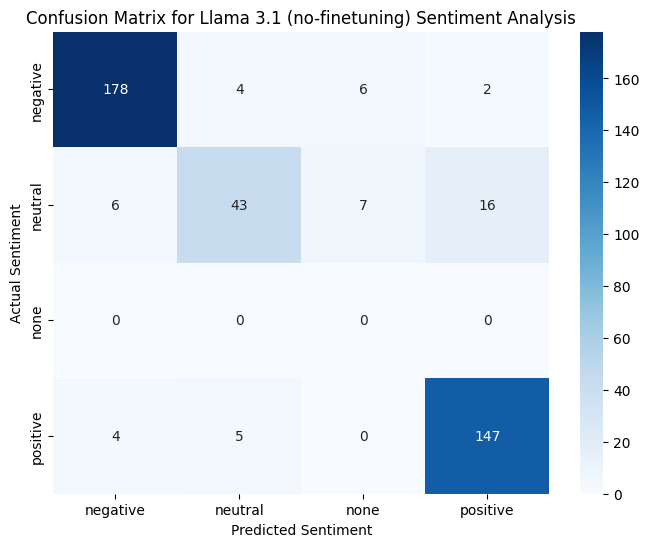

In [32]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=["negative", "neutral","none", "positive"])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral',"none", 'positive'], yticklabels=['negative', 'neutral',"none", 'positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Llama 3.1 (no-finetuning) Sentiment Analysis')
plt.show()

# Finetuning

In [33]:
eval_data

Dataset({
    features: ['prompt', 'actual_sentiment'],
    num_rows: 420
})

In [34]:
train_data

Dataset({
    features: ['prompt', 'actual_sentiment'],
    num_rows: 1951
})

In [35]:
output_dir="trained_weigths"

peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules=["q_proj", "v_proj"],  # Specify exact linear layers (adjust based on model architecture)
        task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,                             # max step as -1 to use all epochs
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
#     report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    max_seq_length=1024,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

Map:   0%|          | 0/1951 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [36]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_api")
import wandb
! wandb login $wandb_key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [37]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: yorkyong-yeo (yorkyong). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
0,1.432200,1.123467


TrainOutput(global_step=243, training_loss=1.0828393123767994, metrics={'train_runtime': 2433.6653, 'train_samples_per_second': 0.802, 'train_steps_per_second': 0.1, 'total_flos': 7498632375336960.0, 'train_loss': 1.0828393123767994, 'epoch': 0.9964120963608406})

In [38]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.json')

- Save notebook

# Clean up memory

In [39]:
import gc

del [
    model, 
     tokenizer, 
     peft_config, 
    trainer, 
    train_data, 
    eval_data, 
    bnb_config, 
    training_arguments
]
# del [df, X_train, X_eval]
del [
    TrainingArguments, 
    SFTTrainer, 
    LoraConfig, 
    BitsAndBytesConfig
]

In [40]:
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [41]:
!nvidia-smi

Sun Oct 20 15:35:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             35W /  250W |     619MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load weights to model for testing

In [42]:
from transformers import (AutoConfig,
                          AutoModelForCausalLM, 
                          AutoTokenizer,
                          LlamaForCausalLM, 
                          LlamaTokenizer,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)

In [43]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify model name and path
model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
peft_model_id = "/kaggle/working/trained_weigths"
# peft_model_id = "/kaggle/input/sentiment-analysis-with-llama-3-1/trained_weigths"

In [44]:
# Set computation dtype
compute_dtype = getattr(torch, "float16")

# Configure bits and bytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True
)

# Load the base model with CPU offloading
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
print(len(tokenizer))

128258


In [46]:
# Load the PEFT adapter
model.load_adapter(peft_model_id)

# Configure model settings
model.config.use_cache = False
model.config.pretraining_tp = 1

# Ensure the model is in evaluation mode
model.eval()

print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [47]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 418/418 [04:47<00:00,  1.45it/s]


In [48]:
evaluate(y_true, y_pred)

Accuracy: 0.921
Accuracy for label 0: 0.979
Accuracy for label 1: 0.847
Accuracy for label 2: 0.885

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       190
           1       0.79      0.85      0.82        72
           2       0.97      0.88      0.93       156

    accuracy                           0.92       418
   macro avg       0.90      0.90      0.90       418
weighted avg       0.92      0.92      0.92       418


Confusion Matrix:
[[186   4   0]
 [  7  61   4]
 [  6  12 138]]


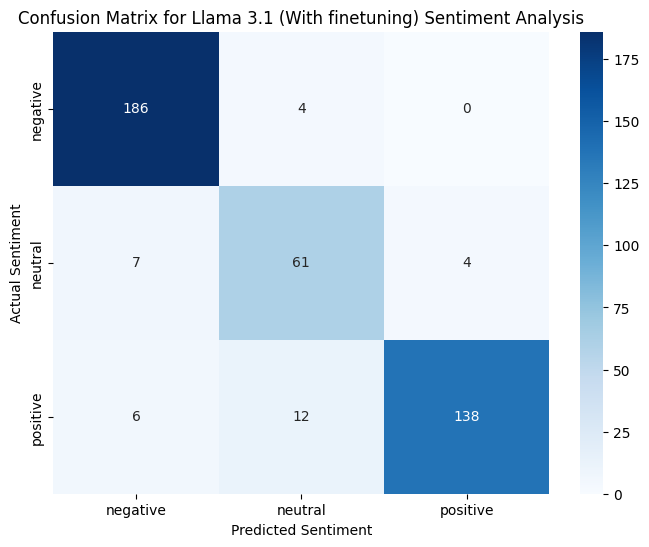

In [49]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=["negative", "neutral", "positive"])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Llama 3.1 (With finetuning) Sentiment Analysis')
plt.show()